# Electricity Consumption: Basic EDA and Data Cleaning

## Loading Libraries and Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import holidays
us_holidays = holidays.US()
from Time_series_helpers import plot_holiday_impact

## Loading Raw Data

In [3]:
elec = pd.read_csv('data/raw/PJME_hourly.csv', index_col=[0], parse_dates=True)

elec.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
elec.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [5]:
elec.index.min()

Timestamp('2002-01-01 01:00:00')

In [6]:
elec.index.max()

Timestamp('2018-08-03 00:00:00')

## Data Cleaning

### Re-arranging the data by date

The first thing that we can notice above is that the earliest data is not right at the beginning of the dataframe, and the last rows of the dataframe also don't correspond to the latest data. So we should sort our data properly.

In [7]:
elec_ordered = elec.sort_index()

### Checking for duplicate values

In [8]:
sum(elec_ordered.index.duplicated())

4

There are 4 duplicated values; let's look at them to see what they correspond to


In [9]:
elec_ordered[elec_ordered.index.duplicated()]

,PJME_MW
Datetime,
2014-11-02 02:00:00,22935.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,20666.0


We see that the duplicate values are always in November, at 2 in the morning. This means that they must be related to daylight saving time. What is strange is that there are only 4 years in the data for which these values occur: let's look at this more closely.

In [10]:
elec_ordered['November 2014'].iloc[20:30,]

,PJME_MW
Datetime,
2014-11-01 20:00:00,30264.0
2014-11-01 21:00:00,29695.0
2014-11-01 22:00:00,28829.0
2014-11-01 23:00:00,27430.0
2014-11-02 00:00:00,25838.0
2014-11-02 01:00:00,23538.0
2014-11-02 02:00:00,23755.0
2014-11-02 02:00:00,22935.0
2014-11-02 03:00:00,22789.0


In 2014, we see that the index value appears twice at 2 AM: this confirms our intuition about DST: in November, the clock moves back one hour during the night on the first Sunday. Therefore, two consecutive values have the same timestamp. 

Now let's see how this was dealt with in previous years, for which there is no duplicate value.

Based on data from https://www.timeanddate.com/time/change/usa/new-york , in 2013, the date of daylight saving time end was Sunday, November 3, at 2am.


In [11]:
elec_ordered['November 2013'].iloc[45:55]

,PJME_MW
Datetime,
2013-11-02 21:00:00,27598.0
2013-11-02 22:00:00,26677.0
2013-11-02 23:00:00,25329.0
2013-11-03 00:00:00,23678.0
2013-11-03 01:00:00,22226.0
2013-11-03 03:00:00,20465.0
2013-11-03 04:00:00,20477.0
2013-11-03 05:00:00,20773.0
2013-11-03 06:00:00,21495.0


We see something interesting here: for 2013, the value, or rather what should have been the two values, at 2 AM was simply removed; let's check if this was also the case in previous years.

In [12]:
elec_ordered['27/10/2002'].head()

,PJME_MW
Datetime,
2002-10-27 00:00:00,24387.0
2002-10-27 01:00:00,22823.0
2002-10-27 03:00:00,20605.0
2002-10-27 04:00:00,20534.0
2002-10-27 05:00:00,20743.0


In [13]:
elec_ordered['31/10/2004'].head()

,PJME_MW
Datetime,
2004-10-31 00:00:00,24917.0
2004-10-31 01:00:00,23027.0
2004-10-31 03:00:00,20585.0
2004-10-31 04:00:00,20381.0
2004-10-31 05:00:00,20528.0


In [14]:
elec_ordered['11/2/08'].head()

,PJME_MW
Datetime,
2008-11-02 00:00:00,25369.0
2008-11-02 01:00:00,23744.0
2008-11-02 03:00:00,21631.0
2008-11-02 04:00:00,21560.0
2008-11-02 05:00:00,21988.0


Based on the sample of 3 years above, there seems to be enough evidence that the duplicated data was simply removed for years prior to 2014. For the years after that, we'll remove the duplicates, but keep one value for 2 AM.

In [15]:
elec_ordered['date'] = elec_ordered.index
elec_ordered.drop_duplicates(subset='date', inplace=True)
elec_ordered = elec_ordered.drop('date', axis='columns')

### Changing the index from Timestamp to Periods

The data that we have for each hour represents electricity consumption over the period of one hour, rather than at the instant. Therefore, we change the index to a period index to reflect this.

In [16]:
elec_ordered.index.to_period('H')

PeriodIndex(['2002-01-01 01:00', '2002-01-01 02:00', '2002-01-01 03:00',
             '2002-01-01 04:00', '2002-01-01 05:00', '2002-01-01 06:00',
             '2002-01-01 07:00', '2002-01-01 08:00', '2002-01-01 09:00',
             '2002-01-01 10:00',
             ...
             '2018-08-02 15:00', '2018-08-02 16:00', '2018-08-02 17:00',
             '2018-08-02 18:00', '2018-08-02 19:00', '2018-08-02 20:00',
             '2018-08-02 21:00', '2018-08-02 22:00', '2018-08-02 23:00',
             '2018-08-03 00:00'],
            dtype='period[H]', name='Datetime', length=145362, freq='H')

### Saving the cleaned up file for future use

In [17]:
elec_ordered.to_csv('data/processed/elec_clean.csv')

## Basic exploration of trends

#### Yearly Trend

<AxesSubplot:title={'center':'Electricity Consumption by Year, US East, 2002-2018'}, xlabel='Datetime'>

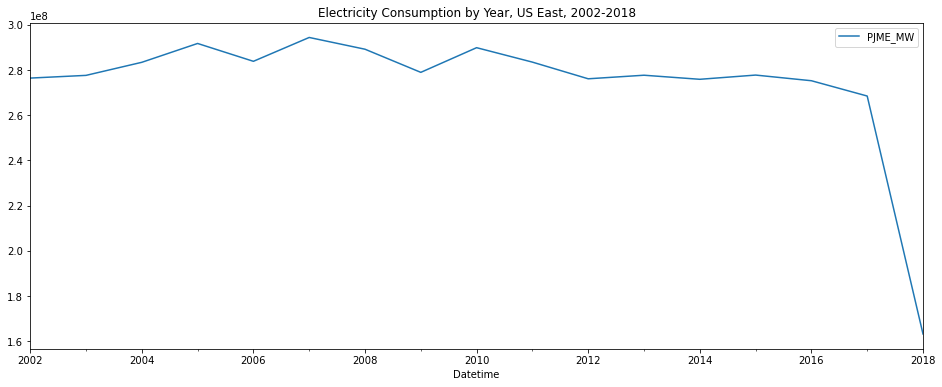

In [29]:
yearly_elec = elec_ordered.resample('Y').sum()
yearly_elec.plot(figsize = (16,6), title = 'Electricity Consumption by Year, US East, 2002-2018')

There is no clear yearly trend, especially from 2012, yearly consumption is basically flat. The big drop in 2018 is just because for that year the data stops in August.

#### Monthly Trend

<AxesSubplot:title={'center':'Electricity Consumption by Month, US East, 2002-2017'}, xlabel='Datetime'>

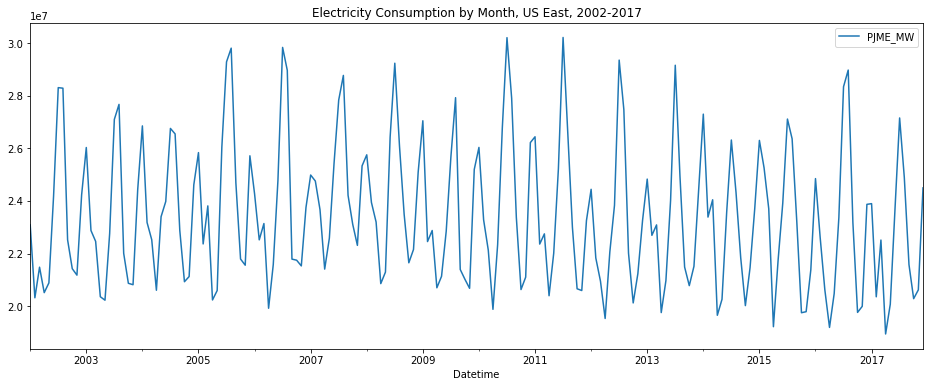

In [30]:
elec_b18 = elec_ordered[elec_ordered.index < '2018']
monthly_elec = elec_b18.resample('M').sum()
monthly_elec.plot(figsize=(16,6), title = 'Electricity Consumption by Month, US East, 2002-2017')

There are clearly two spikes during a year, one in the winter and one in the summer. Generally, the one in the summer is higher. Let's zoom in on a shorter period to see this better.

<AxesSubplot:title={'center':'Monthly Electricty Consumption, US East, 2002-2003'}, xlabel='Datetime'>

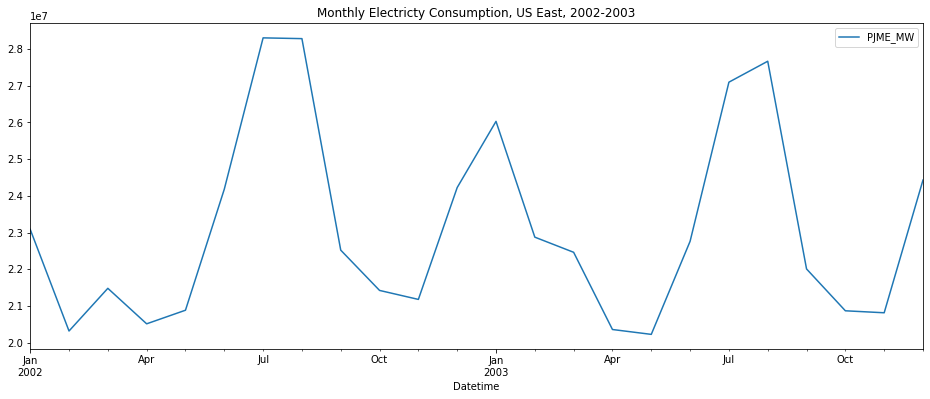

In [31]:
monthly_elec[monthly_elec.index < '2004'].plot(figsize = (16,6), title = 'Monthly Electricty Consumption, US East, 2002-2003')

#### Daily Trend

<AxesSubplot:title={'center':'Daily Electricity Consumption, US East, 2010'}, xlabel='Datetime'>

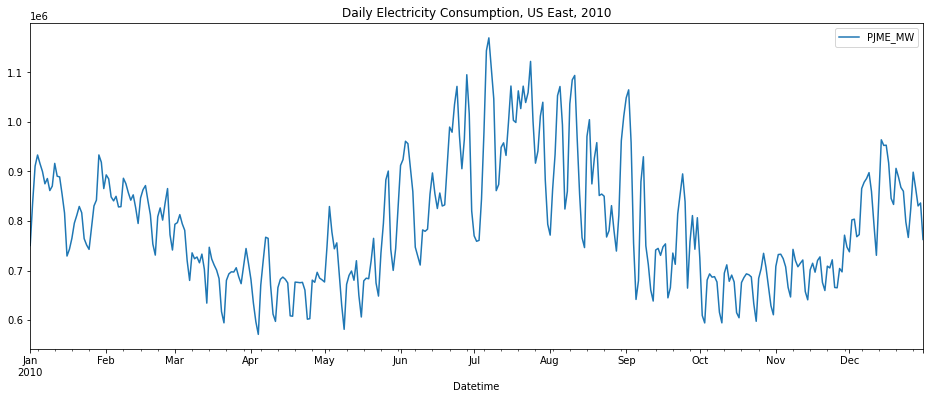

In [32]:
daily_elec = elec_b18.resample('D').sum()
daily_elec['2010'].plot(figsize=(16,6), title = 'Daily Electricity Consumption, US East, 2010')

We can see a regular dip, which corresponds to weekends. The very big dip in early July could correspond to the 4th of July, which means holidays need to be explored.

#### Holidays and their impact

In [22]:
#looking at 2003
o_three = daily_elec['2003']
o_three['date'] = o_three.index.date
o_three['holiday'] = o_three['date'].apply(lambda d: d in us_holidays)
o_three_holidays = o_three.loc[o_three.holiday == True].index

In [23]:
#looking at 2010
twenty_ten = daily_elec['2010']
twenty_ten['date'] = twenty_ten.index.date
twenty_ten['holiday'] = twenty_ten['date'].apply(lambda d: d in us_holidays)
twenty_ten_holidays = twenty_ten.loc[twenty_ten.holiday == True].index

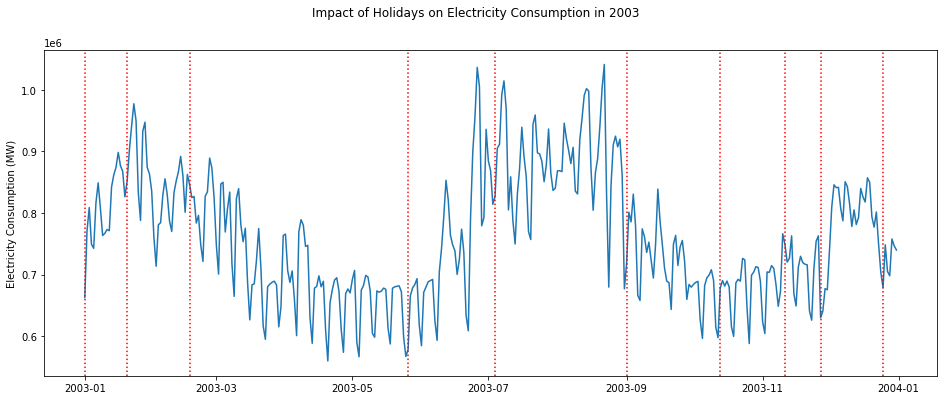

In [24]:
plot_holiday_impact(o_three, o_three_holidays, 'Impact of Holidays on Electricity Consumption in 2003')

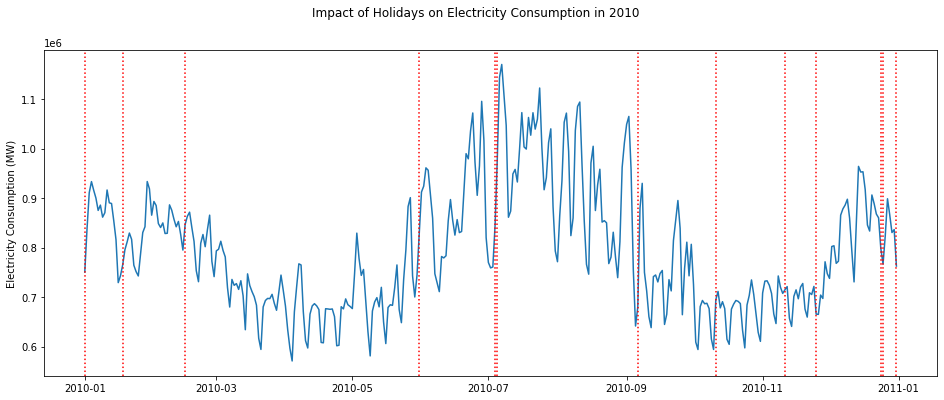

In [25]:
plot_holiday_impact(twenty_ten, twenty_ten_holidays, 'Impact of Holidays on Electricity Consumption in 2010')

Obviously, not all holidays have the same impact. 

Fourth of July, and Labor day the holiday that takes place in early September, seem to have the most impact on energy consumption. 

Interestingly, well known holidays like Thanksgiving and Christmas have relatively much lower impact.

#### Weekly trends

<AxesSubplot:title={'center':'Mean electricity consumption (MW) by day of the week, US East, 2002-2017'}, xlabel='weekday'>

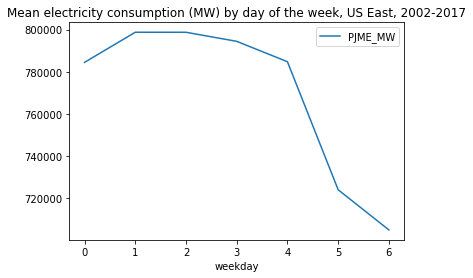

In [33]:
daily_elec['weekday'] = daily_elec.index.dayofweek
daily_elec.groupby('weekday').mean().plot(title = 'Mean electricity consumption (MW) by day of the week, US East, 2002-2017')

There is a clear drop of electricity consumption in the weekend. 
Monday and Friday have slightly lower electricity consumption than other working days.